# Testing transformations

In [103]:
using Plots
using LinearAlgebra
using DifferentialEquations

In [111]:
plotly()

┌ Info: For saving to png with the Plotly backend PlotlyBase and PlotlyKaleido need to be installed.
└ @ Plots C:\Users\yshimane3\.julia\packages\Plots\AAjgN\src\backends.jl:319


Plots.PlotlyBackend()

In [42]:
include("../src/SailorMoon.jl")   # relative path to main file of module

Main.SailorMoon

In [78]:
include("../../julia-r3bp/R3BP/src/R3BP.jl")

Main.R3BP

In [43]:
params = SailorMoon.dyanmics_parameters()

Main.SailorMoon.dynamics_params(0.987849414390376, 0.01215058560962404, 328900.5598102475, 384748.32292972936, 375700.3437894195, 388.8212386592645, -0.9251999994040079, 1.0)

In [47]:
params.oms

-0.9251999994040079

In [44]:
?SailorMoon.transform_EMrot_to_SunB1

```
transform_EMrot_to_SunB1(state::Vector, θs::Real, ωs::Real)
```

Transform state from Earth-Moon rotating frame to Sun-B1 rotating frame. Careful with sign of ωs!! (should be negative)


In [45]:
lps = SailorMoon.lagrange_points(params.mu2)

5×6 Matrix{Float64}:
  0.836915   0.0       0.0  0.0  0.0  0.0
  1.15568    0.0       0.0  0.0  0.0  0.0
 -1.00506    0.0       0.0  0.0  0.0  0.0
  0.487849   0.866025  0.0  0.0  0.0  0.0
  0.487849  -0.866025  0.0  0.0  0.0  0.0

In [104]:
thetas = LinRange(0, 2π, 100)
xs_earth_circle = [-mu*cos(theta) for theta in thetas];
ys_earth_circle = [-mu*sin(theta) for theta in thetas];
xs_moon_circle = [(1-mu)*cos(theta) for theta in thetas];
ys_moon_circle = [(1-mu)*sin(theta) for theta in thetas];

In [144]:
lp = 2
Az_km = 28000.0
println("Halo guess Az_km: $Az_km")
northsouth = 3   # 1 or 3
guess0 = R3BP.halo_analytical_construct(params.mu2, lp, Az_km, params.lstar, northsouth)
res = R3BP.ssdc_periodic_xzplane([params.mu2,], guess0.x0, guess0.period, fix="z")

Halo guess Az_km: 28000.0


Main.R3BP.SingleShootingSolution([1.0883641744470323, 0.0, -0.06062187841543154, 0.0, 0.2655967803667477, 0.0], 3.331057043849101, 1, Any[0.15262223845485157, 0.11015253334732933, 0.019132050960180263, 0.0019868429639584265, 2.7747171706852208e-5, 9.441367998507001e-10, 3.640166498265556e-14])

In [145]:
res.period*params.tstar/86400

14.484713849030959

In [146]:
res.x0

6-element Vector{Float64}:
  1.0883641744470323
  0.0
 -0.06062187841543154
  0.0
  0.2655967803667477
  0.0

In [176]:
prob = ODEProblem(R3BP.rhs_cr3bp_sv!, res.x0, (0, 5res.period), [params.mu2])
sol = solve(prob, Tsit5(), reltol=1e-12, abstol=1e-12);
coord = hcat(sol.u...)

6×1715 Matrix{Float64}:
  1.08836     1.08836       1.08836      …   1.15494      1.15536
  0.0         0.000454305   0.000994316     -0.155807    -0.155823
 -0.0606219  -0.0606211    -0.0606184       -0.0583901   -0.0588155
  0.0         8.9734e-5     0.000196422      0.106789     0.107906
  0.265597    0.265594      0.265583        -0.00389294  -0.00440579
  0.0         0.000855542   0.00187245   …  -0.110186    -0.10984

In [177]:
ptraj = plot(frame_style=:box, size=(700,700))
plot!(ptraj, coord[1,:], coord[2,:], coord[3,:], linewidth=2.0)
scatter!(ptraj, lps[1:2,1], lps[1:2,2], lps[1:2,3], 
    marker=:cross, color=:black, label="LPs, EM-frame")
ptraj

In [178]:
coord_sb1 = zeros(6,length(sol.t))
θs_0 = 0
for i = 1:length(sol.t)
    θs = θs_0 + sol.t[i] * params.oms
    coord_sb1[:,i] = SailorMoon.transform_EMrot_to_SunB1(coord[:,i], θs, params.oms)
end

In [182]:
gr()

Plots.GRBackend()

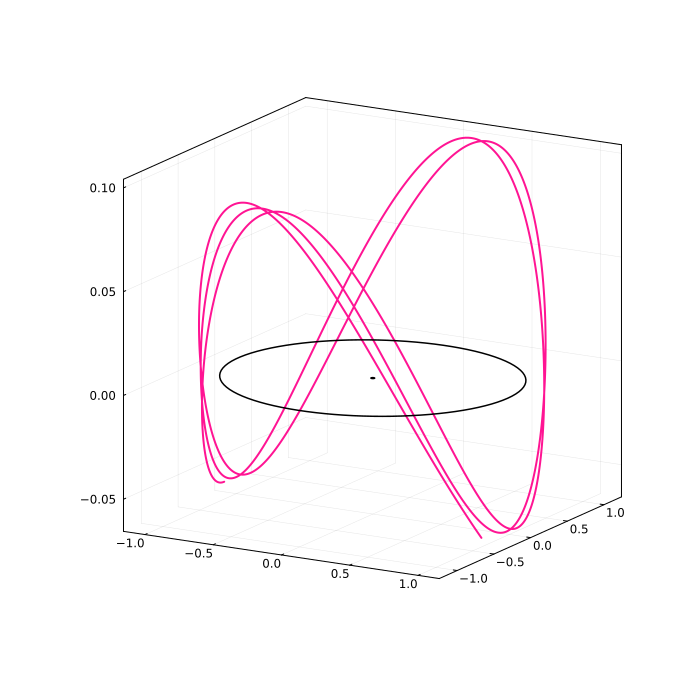

In [190]:
ptraj = plot(frame_style=:box, size=(700,700), legend=false, camera=(30,15))
plot!(ptraj, coord_sb1[1,:], coord_sb1[2,:], coord_sb1[3,:], linewidth=2.0, color=:deeppink)

plot!(ptraj, xs_earth_circle, ys_earth_circle, zeros(length(thetas)), linewidth=1.5, color=:black)
plot!(ptraj, xs_moon_circle, ys_moon_circle, zeros(length(thetas)), linewidth=1.5, color=:black)

ptraj

In [67]:
lps_sb1 = zeros(5,6)
θs = deg2rad(35)

for i = 1:5
    lps_sb1[i,:] = SailorMoon.transform_EMrot_to_SunB1(lps[i,:], θs, params.oms)
end

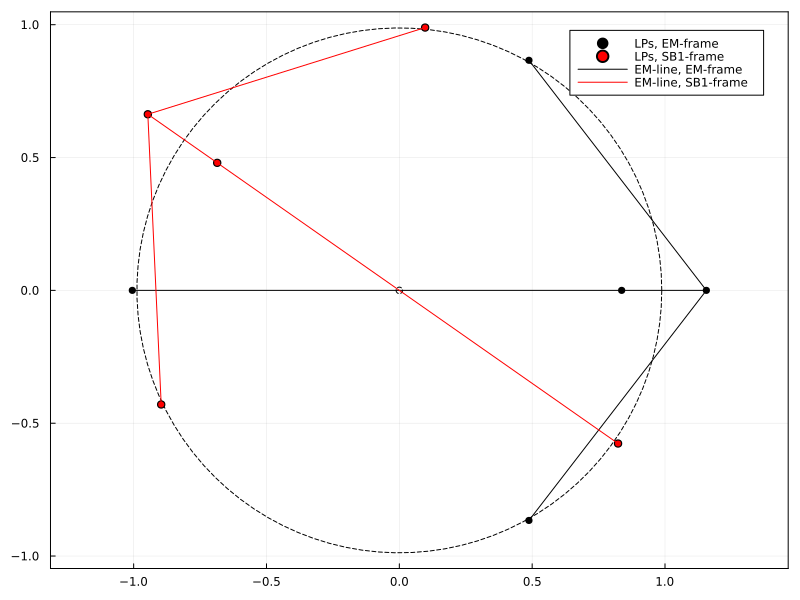

In [77]:
pconv = plot(frame_style=:box, size=(800,600), aspect_ratio=:equal)
plot!(pconv, xs_earth_circle, ys_earth_circle, color=:black, linestyle=:dash, label=false)
plot!(pconv, xs_moon_circle, ys_moon_circle, color=:black, linestyle=:dash, label=false)

scatter!(pconv, lps[:,1], lps[:,2], marker=:circle, color=:black, label="LPs, EM-frame")
scatter!(pconv, lps_sb1[:,1], lps_sb1[:,2], marker=:circle, color=:red, label="LPs, SB1-frame")

plot!(pconv, [lps[2,1], lps[3,1]], [lps[2,2], lps[3,2]], color=:black, label="EM-line, EM-frame")
# plot!(pconv, [0, lps[4,1]], [lps[2,2], lps[4,2]], color=:black, label=false)
# plot!(pconv, [0, lps[5,1]], [lps[2,2], lps[5,2]], color=:black, label=false)
plot!(pconv, [lps[2,1], lps[4,1]], [lps[2,2], lps[4,2]], color=:black, label=false)
plot!(pconv, [lps[2,1], lps[5,1]], [lps[2,2], lps[5,2]], color=:black, label=false)

plot!(pconv, [lps_sb1[2,1], lps_sb1[3,1]], [lps_sb1[2,2], lps_sb1[3,2]], color=:red, label="EM-line, SB1-frame")
plot!(pconv, [lps_sb1[2,1], lps_sb1[4,1]], [lps_sb1[2,2], lps_sb1[4,2]], color=:red, label=false)
plot!(pconv, [lps_sb1[2,1], lps_sb1[5,1]], [lps_sb1[2,2], lps_sb1[5,2]], color=:red, label=false)

pconv